In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.lsm import _traveltime_table, Demigration, LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

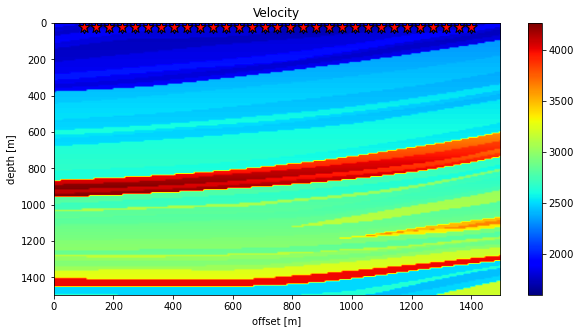

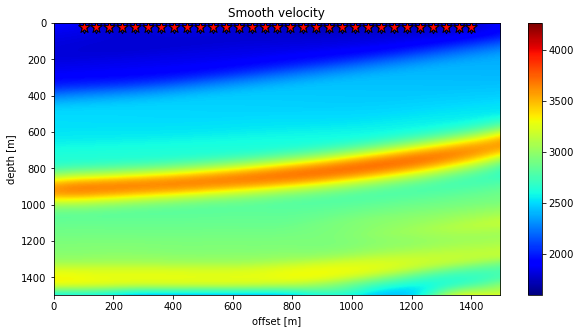

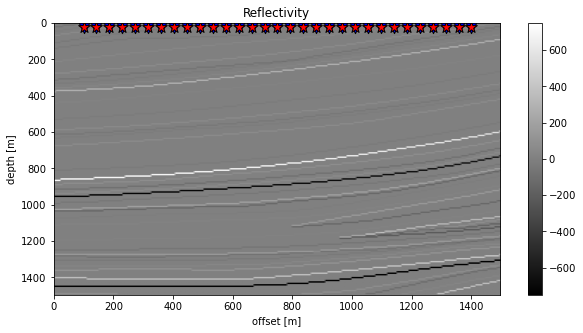

In [2]:
dx, dz = 4, 4

#Velocity
inputfile='../../../pylops_notebooks/data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = (model['x'] - model['x'][0])[250:625], (model['z'] - model['z'][0])[0:375], (1000*model['model'].T)[250:625,0:375]
x = np.arange(0,max(x)-min(x)+1, 4)
nx, nz = len(x), len(z)
dx, dz = 4, 4

# Reflectivity
refl = np.diff(vel_true, axis=1)
refl = np.hstack([refl, np.zeros((nx, 1))])

# Smooth velocity
v0 = 1600 # initial velocity
nsmooth=30
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel, axis=1)

# Receivers
nr = 31
rx = np.linspace(dx*25, (nx-25)*dx, nr)
# rx = np.linspace(dx, (nx)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 31
sx = np.linspace(dx*25, (nx-25)*dx, ns)
# sx = np.linspace(dx, (nx)*dx, ns)
sz = 20*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

# Display
velmin = 1600
velmax = np.abs(-1*vel_true).max()

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='jet', vmin = velmin, vmax = velmax,
                extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('offset [m]'),plt.ylabel('depth [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='jet', vmin = velmin, vmax = velmax, 
                extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('offset [m]'),plt.ylabel('depth [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

reflmax = np.abs(-1*refl).max()
reflmin = -np.abs(-1*refl).max()

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', vmin = reflmin, vmax = reflmax, 
                extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('offset [m]'),plt.ylabel('depth [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0]);


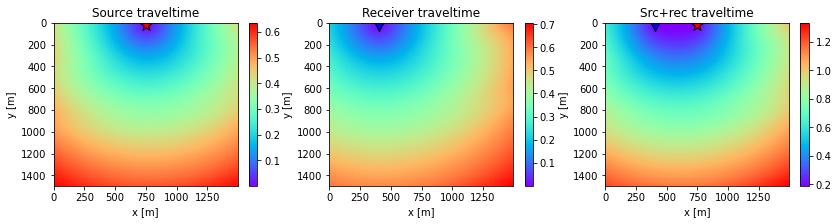

In [3]:
trav, trav_srcs, trav_recs = _traveltime_table(z, x, sources, recs, vel, mode='eikonal')   

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

In [4]:
# Perform LS on velocity model
nt = 400
dt = 0.004
t = np.arange(nt)*dt

# Generate the ricker wavelet
itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

Sop = Spread(dims=(nx, nz), dimsd=(ns*nr, nt), table=itrav, dtable=travd, engine='numba')
dottest(Sop, ns*nr*nt, nx*nz)

wav, wavt, wavc = ricker(t[:41], f0=20)
Cop = Convolve1D(ns*nr*nt, h=wav, offset=wavc, dims=(ns*nr, nt), dir=1)

LSMop = Cop*Sop
LSMop = LinearOperator(LSMop, explicit=False)

# Generate the data
d = LSMop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = LSMop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = LSMop.div(d.ravel(), niter=100)
minv = minv.reshape(nx, nz)

# demigration
dadj = LSMop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

In [5]:
# Perform LS on reflectivity model
lsm = LSM(z, x, t, sources, recs, vel, wav, wavc,
          mode='eikonal')
d = lsm.Demop * refl.ravel()
d = d.reshape(ns, nr, nt)

# Adjoint
madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

# LS solution
minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(nx, nz)

# Demigration

# adjoint
dadj = LSMop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

# LS solution
dinv = LSMop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 384400 rows and 140625 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.333e+07  1.333e+07    1.0e+00  6.6e-05
     1 -5.98810e-01   6.773e+06  6.773e+06    5.1e-01  7.9e-01   1.0e+03  1.0e+00
     2 -7.76358e-01   5.207e+06  5.207e+06    3.9e-01  5.3e-01   1.7e+03  2.2e+00
     3 -8.71207e-01   3.999e+06  3.999e+06    3.0e-01  2.9e-01   2.5e+03  4.0e+00
     4 -8.95353e-01   3.038e+06  3.038e+06    2.3e-01  2.0e-01   2.8e+03  5.7e+00
     5 -7.99199e-01   2.290e+06  2.290e+06    1.7e-01  1.6e-01   3.0e+03  7.6e+00
     6 -4.75858e-01   1.782e+06  1.782e+06    1.3e-01  1.3e-01   3.2e+03  9.6e+00
     7 -1.86192e-02   1.442e+06  1.442e+06    1.1e-01  1.2e-01   3.3e+03  1.2e+01
     8  1.72928e-01   1.211e+0

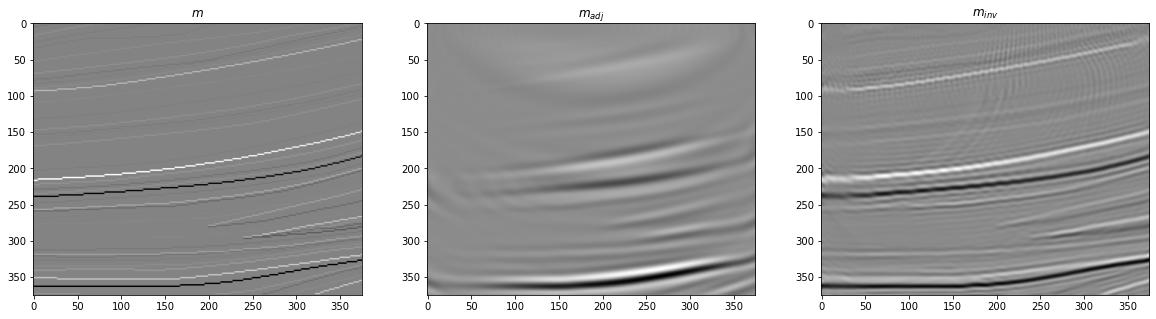

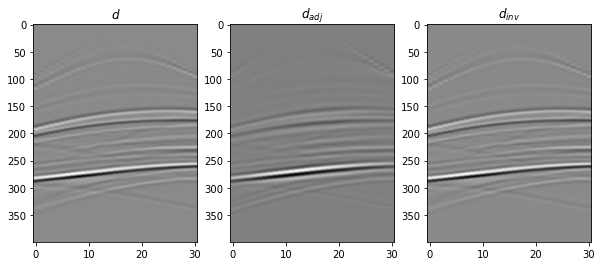

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(refl.T, cmap='gray')
axs[0].axis('tight')
axs[0].set_title(r'$m$')
axs[1].imshow(madj.T, cmap='gray')
axs[1].set_title(r'$m_{adj}$')
axs[1].axis('tight')
axs[2].imshow(minv.T, cmap='gray')
axs[2].axis('tight')
axs[2].set_title(r'$m_{inv}$');

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(d[ns//2, :, :500].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :500].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :500].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight');

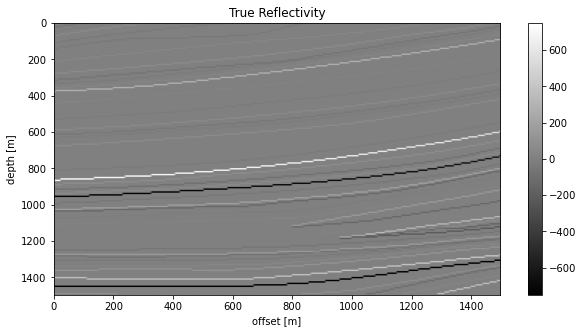

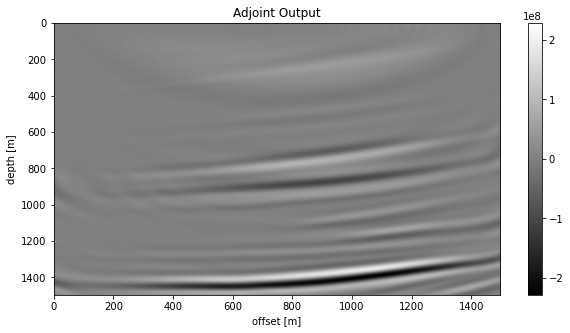

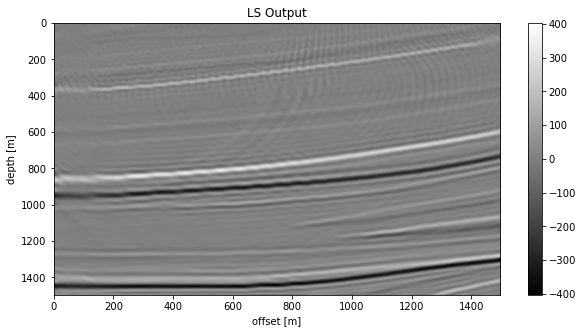

In [8]:
reflmax = np.abs(-1*refl).max()
reflmin = -np.abs(-1*refl).max()

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', vmin = reflmin, vmax = reflmax, 
                extent = (x[0], x[-1], z[-1], z[0]))
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('offset [m]'),plt.ylabel('depth [m]')
plt.title('True Reflectivity')
plt.ylim(z[-1], z[0]);

madjmax = np.abs(-1*madj).max()
madjmin = -np.abs(-1*madj).max()

plt.figure(figsize=(10,5))
im = plt.imshow(madj.T, cmap='gray', vmin = madjmin, vmax = madjmax, 
                extent = (x[0], x[-1], z[-1], z[0]))
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('offset [m]'),plt.ylabel('depth [m]')
plt.title('Adjoint Output')
plt.ylim(z[-1], z[0]);

minvmax = np.abs(-1*minv).max()
minvmin = -np.abs(-1*minv).max()

plt.figure(figsize=(10,5))
im = plt.imshow(minv.T, cmap='gray', vmin = minvmin, vmax = minvmax, 
                extent = (x[0], x[-1], z[-1], z[0]))
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('offset [m]'),plt.ylabel('depth [m]')
plt.title('LS Output')
plt.ylim(z[-1], z[0]);